In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
airline_df = pd.read_csv('data\\raw\\airlines.csv')
airline_df.sample(5)

,IATA_CODE,AIRLINE
6,AS,Alaska Airlines Inc.
13,VX,Virgin America
1,AA,American Airlines Inc.
0,UA,United Air Lines Inc.
9,DL,Delta Air Lines Inc.


In [3]:
airport_df = pd.read_csv('data\\raw\\airports.csv')
airport_df.sample(5)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
304,TRI,Tri-Cities Regional Airport,Bristol,TN,USA,36.47521,-82.40742
45,BRW,Wiley Post-Will Rogers Memorial Airport,Barrow,AK,USA,71.28545,-156.76600
72,COS,City of Colorado Springs Municipal Airport,Colorado Springs,CO,USA,38.80581,-104.70025
233,PAH,Barkley Regional Airport,Paducah,KY,USA,37.06083,-88.77375
229,ORF,Norfolk International Airport,Norfolk,VA,USA,36.89461,-76.20122


In [4]:
flight_df = pd.read_csv('data\\raw\\flights.csv')
flight_df.sample(5)

C:\Users\julim\AppData\Local\Temp\ipykernel_35568\2406861582.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flight_df = pd.read_csv('data\\raw\\flights.csv')


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
3361958,2015,7,29,3,WN,373,N660SW,JAX,BWI,850,...,1047.0,2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4927357,2015,11,4,3,OO,2996,N506CA,DRO,PHX,1230,...,1347.0,-3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5407273,2015,12,5,6,B6,116,N190JB,JFK,SYR,912,...,1020.0,-3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1534371,2015,4,9,4,DL,958,N377NW,CLT,MSP,625,...,801.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
995912,2015,3,6,5,EV,6087,N48901,ORD,ATW,2200,...,2254.0,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cancel_flight_df = flight_df[['CANCELLED', 'CANCELLATION_REASON']]
flight_df.drop(columns=['CANCELLED', 'CANCELLATION_REASON'], inplace=True)
cancel_flight_df.sample(5)

,CANCELLED,CANCELLATION_REASON
2377412,0,NaN
3485339,0,NaN
5746073,0,NaN
5037214,0,NaN
5163529,0,NaN


In [6]:
delay_cols = ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

In [7]:
flight_df['DELAY'] = flight_df['AIR_SYSTEM_DELAY'].astype('Int16') + flight_df['SECURITY_DELAY'].astype('Int16') + flight_df['AIRLINE_DELAY'].astype('Int16') + flight_df['LATE_AIRCRAFT_DELAY'].astype('Int16') + flight_df['WEATHER_DELAY'].astype('Int16')

In [8]:
flight_df['FLIGHT_NUMBER'].corr(flight_df['DELAY'])

np.float64(0.015154871112619482)

In [9]:
flight_df.drop('FLIGHT_NUMBER', axis=1, inplace=True)

In [10]:
flight_df[delay_cols].corrwith(flight_df['DIVERTED']).sort_values(ascending=False)

c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Program Files\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


AIR_SYSTEM_DELAY      NaN
SECURITY_DELAY        NaN
AIRLINE_DELAY         NaN
LATE_AIRCRAFT_DELAY   NaN
WEATHER_DELAY         NaN
dtype: float64

In [11]:
flight_df.drop(columns=['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)

<Axes: >

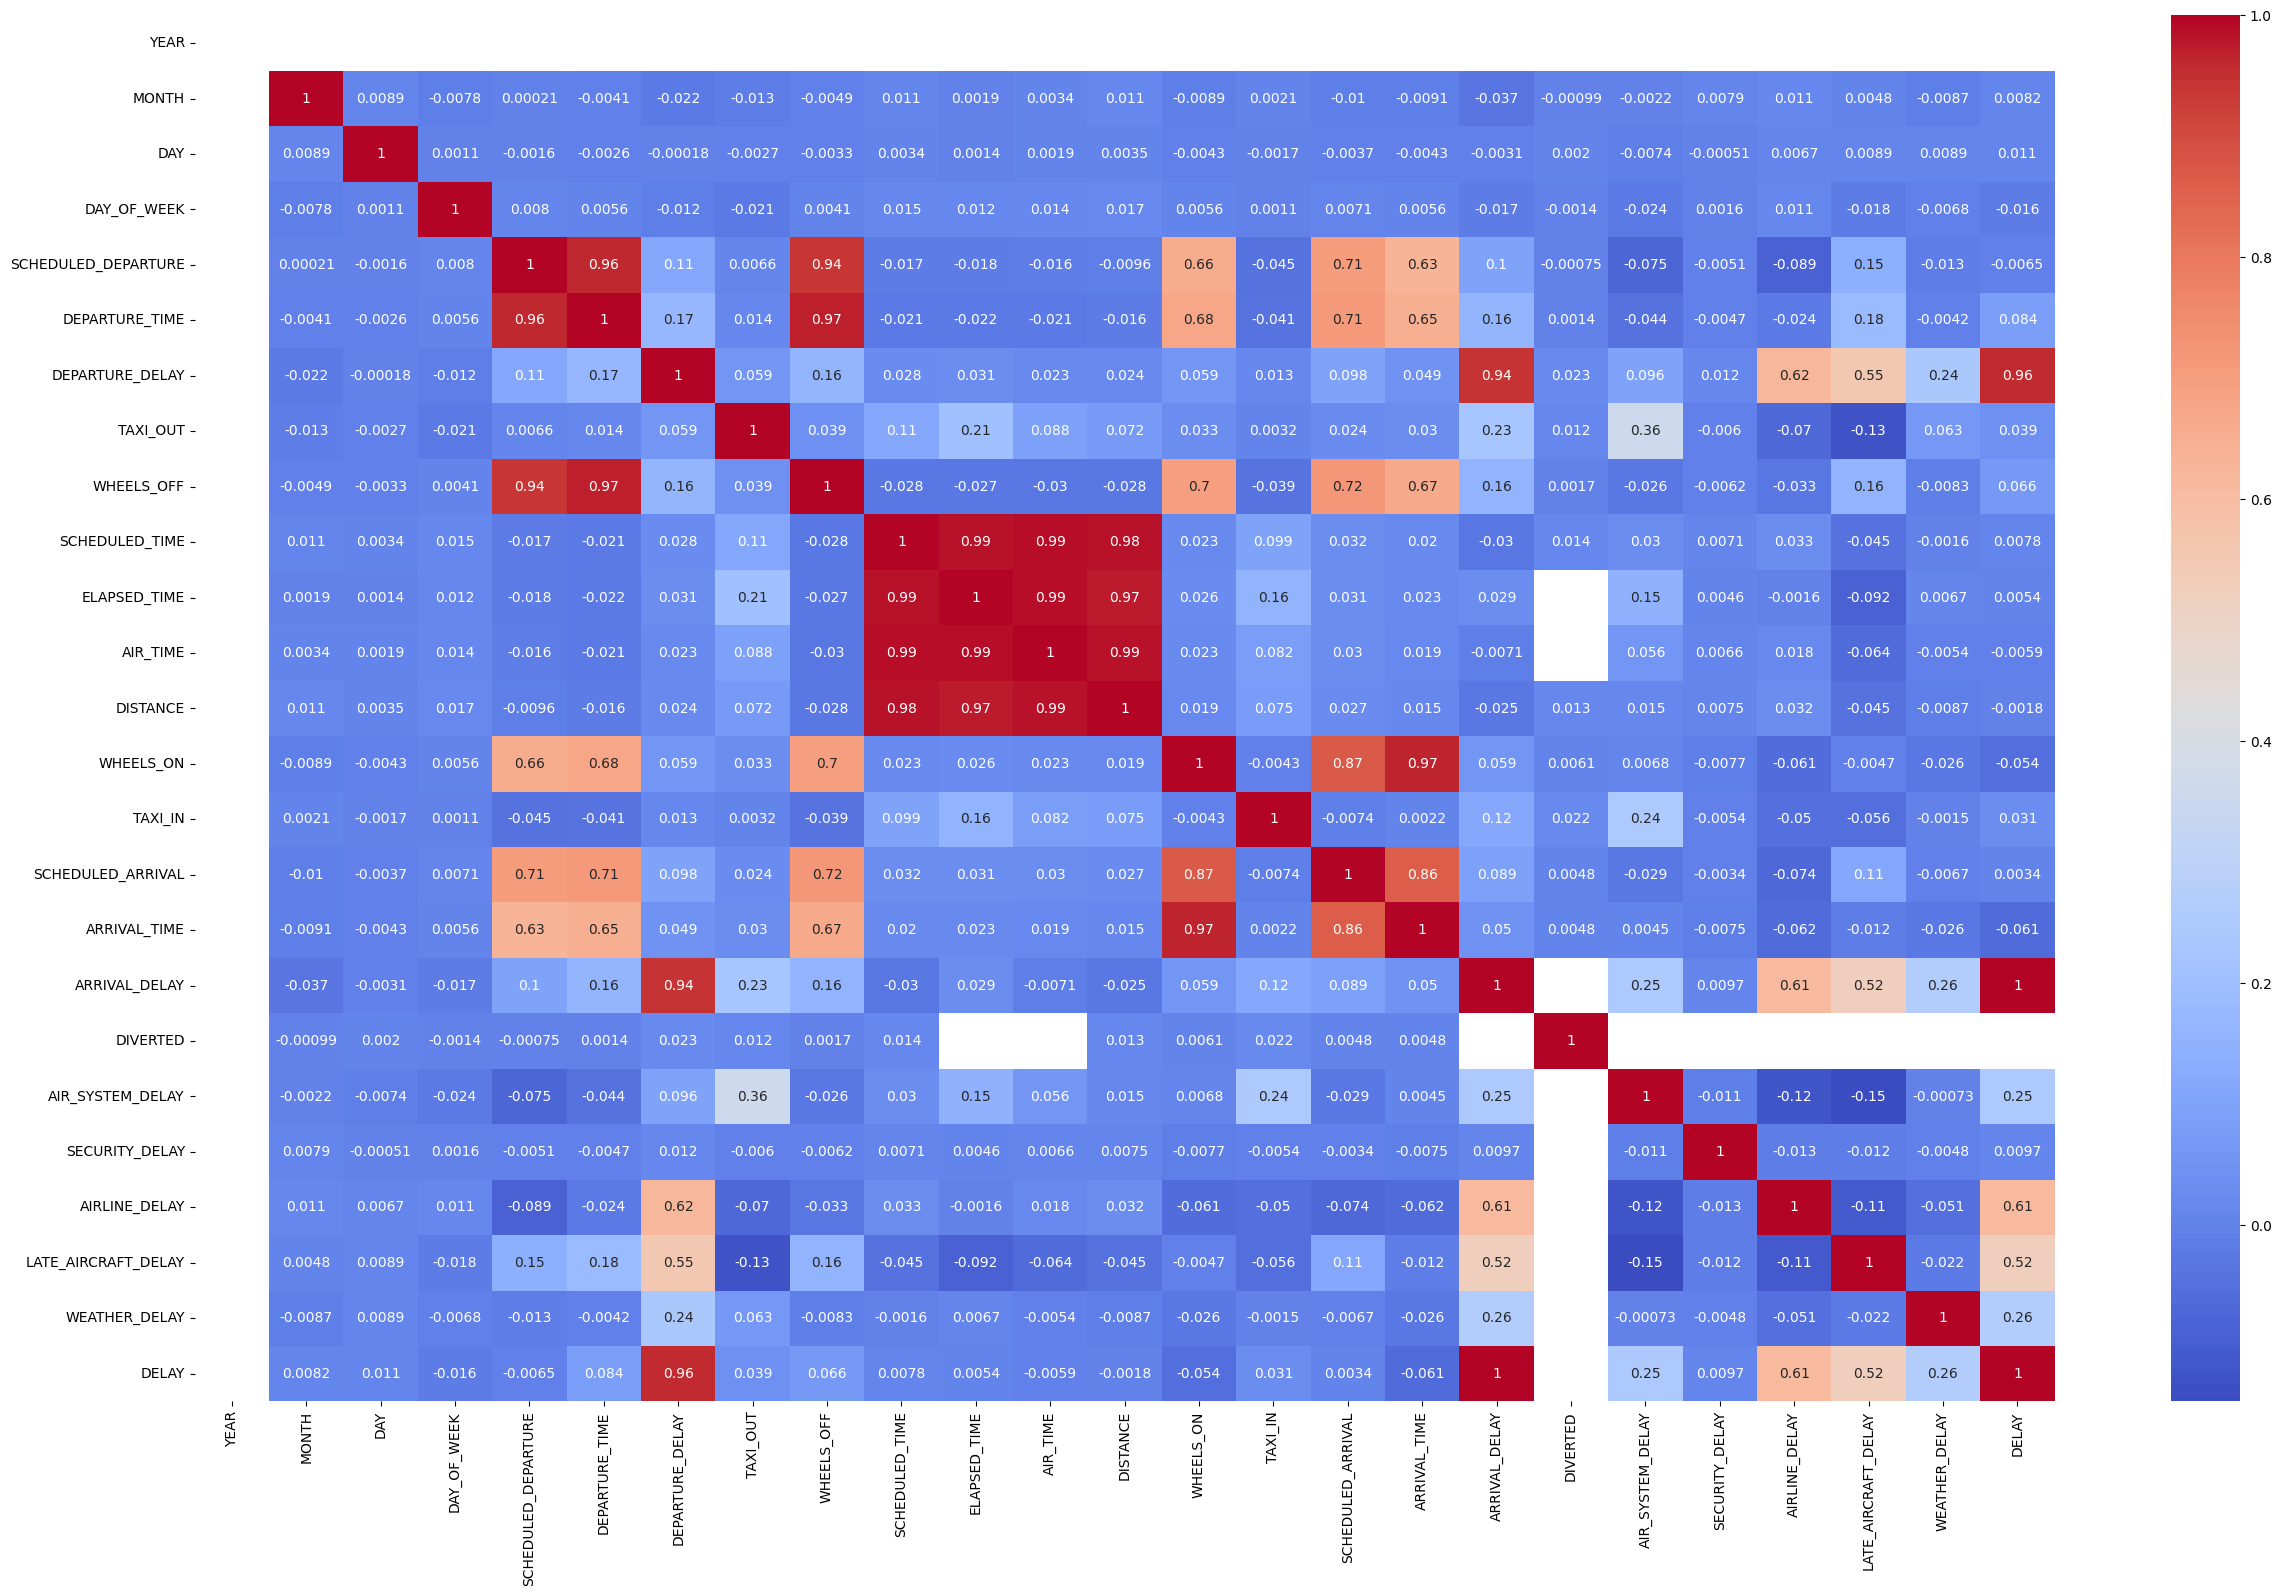

In [12]:
plt.figure(figsize=(30,18))
sns.heatmap(flight_df.corr(), annot=True, cmap='coolwarm')

In [13]:
train_df, test_df = train_test_split(flight_df, test_size=0.2, random_state=42)

x_train = train_df.drop('DELAY', axis=1)
y_train = train_df['DELAY'].fillna(0)
x_test = test_df.drop('DELAY', axis=1)
y_test = test_df['DELAY'].fillna(0)

In [14]:
xgb_model = XGBRegressor(objective='reg:squarederror',
                        n_estimators=100, 
                        learning_rate=0.1, 
                        max_depth=6, 
                        tree_method='hist',
                        device='cuda',
                        random_state=42,
                        n_jobs=-1,
                        verbose=1)
xgb_model.fit(x_train, y_train)

c:\Program Files\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,'cuda'
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [16]:
rf_model = baseline_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",   # good starting heuristic for RF
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rf_model.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 3 of 100
building tree 2 of 100
building tree 4 of 100
building tree 5 of 100
building tree 7 of 100
building tree 6 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 14 of 100
building tree 15 of 100
building tree 12 of 100
building tree 13 of 100
building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.0s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100building tree 40 of 100

building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


,n_estimators,100
,criterion,'squared_error'
,max_depth,25
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
